ENVIRONMENT CONFIGURATION

In [28]:
# Library import

import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn.ensemble as se
import sklearn.metrics as sm
import sklearn.model_selection as sms
import sklearn.preprocessing as sp
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as pyplt
import boruta as bt
import catboost as cb
import optuna
from IPython.display import clear_output
import warnings
import pickle
import os
import random
from datetime import datetime
warnings.simplefilter('ignore')

# Data type redefinition

np.int = np.int64
np.float = np.float64
np.bool = np.bool_

# Definition of used stratified splitter for cross-validation

SKF = sms.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

clear_output()

DATA PREPROCESSING

In [29]:
# converted from .tsv to .csv
# clinical.csv columns: ID1 (originally Study ID), ID2 (originally Sample ID), Age (originally Age at Which Sequencing was Reported), Sex, Type (originally Cancer Type), Subtype (originally Cancer Type Detailed)
# other clinical features from cBioPortal data were not included

# Clinical data import, index definition, sex numerical encoding

base = pd.read_csv("databases/clinical.csv")
base["ID"] = base["ID1"] + ":" + base["ID2"]
base.drop(["ID1", "ID2"], axis=1, inplace=True)
base.set_index("ID", inplace=True)
base.replace({"Sex" : {"Male" : 0, "Female" : 1}}, inplace=True)

# Each batch represents tumor sample data for a portion of the chosen genes (could not be downloaded as a single file)
# converted from .txt to .csv
# batch_n.csv columns: ID (originally Study ID : Sample ID), [GENE FEATURES]
# one batch was initially left out and added as batch_3a to fit alphabetically
# the Altered feature from cBioPortal data was not included

# Gene data import and database concating

for i in range(1, 30):
    path = f"databases/batch_{i}.csv"
    batch = pd.read_csv(path)
    batch.set_index("ID", inplace=True)
    base = pd.concat([base, batch], join="inner", axis=1)
    if(i==3):
        path = f"databases/batch_{i}a.csv"
        batch = pd.read_csv(path)
        batch.set_index("ID", inplace=True)
        base = pd.concat([base, batch], join="inner", axis=1)

# Elimination of unknown age samples and samples containing NaN values

base.dropna(inplace=True)
base.drop(base[base["Age"]==">89"].index, inplace=True)
base.drop(base[base["Age"]=="Unknown"].index, inplace=True)
base.drop(base[base["Age"]=="<18"].index, inplace=True)
base["Age"] = base["Age"].astype(int)

# Prediction vector definition

y1 = base["Type"]
y1 = y1.reset_index()
y1.drop("ID", axis=1, inplace=True)

# Class merger

y1["Type"] = y1["Type"].replace({"Pancreatic Cancer" : "Hepatobiliary/Pancreatic Cancer"})
y1["Type"] = y1["Type"].replace({"Hepatobiliary Cancer" : "Hepatobiliary/Pancreatic Cancer"})
y1["Type"] = y1["Type"].replace({"Small Cell Lung Cancer" : "Lung Cancer"})
y1["Type"] = y1["Type"].replace({"Non-Small Cell Lung Cancer" : "Lung Cancer"})

# Database definition

base.reset_index(inplace=True)
base.drop(["ID", "Type", "Subtype"], axis=1, inplace=True)

# Data import

X = base
y = y1

print(f"Total genes: {len(X.columns)-2}")

# Eliminate single-value columns

cols = X.columns
for i in cols:
  if(len(X[i].unique()) == 1):
    X.drop(i, axis=1, inplace=True)

print(f"Total mutated genes: {len(X.columns)-2}")

# Class numerical encoding

categorical_classes = y["Type"].unique()
numerical_classes = range(len(categorical_classes))
cat_to_num = dict(zip(categorical_classes, numerical_classes))
num_to_cat = dict(zip(numerical_classes, categorical_classes))
y["Type"] = y["Type"].replace(cat_to_num)
classes=y["Type"].unique()
print(f"Classes: {categorical_classes}")

class_counts = list(y["Type"].value_counts(sort=False))

Total genes: 665
Total mutated genes: 566
Classes: ['Colorectal Cancer' 'Ovarian Cancer' 'Melanoma' 'Breast Cancer'
 'Lung Cancer' 'Thyroid Cancer' 'Prostate Cancer'
 'Hepatobiliary/Pancreatic Cancer' 'Bladder Cancer' 'Endometrial Cancer']


COMPONENT FUNCTIONS

In [30]:
# Prepared hypereparameter ranges for Optuna for each model

def RandomForestClassifier_trial_data(trial):
  return {"n_estimators" : trial.suggest_int("n_estimators", 10, 4000, log=True),
            "max_depth" : trial.suggest_int("max_depth", 1, 20),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 20),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 2, 20),
            "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 0, 0.1),
            "min_weight_fraction_leaf" : trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
            "random_state" : trial.suggest_categorical("random_state", [42]),
            "max_features" : trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap" : trial.suggest_categorical("bootstrap", [True, False])}

def XGBoostClassifier_trial_data(trial):
  return {"booster" : "gbtree",
            "n_estimators" : trial.suggest_int("n_estimators", 10, 4000, log=True),
            "max_depth" : trial.suggest_int("max_depth", 1, 20),
            "max_delta_step" : trial.suggest_float("max_delta_step", 0, 10),
            "learning_rate" : trial.suggest_float("learning_rate", 0.05, 1, log=True),
            "alpha" : trial.suggest_float("alpha", 0.01, 100, log=True),
            "gamma" : trial.suggest_float("gamma", 0.01, 1, log=True),
            "lambda" : trial.suggest_float("lambda", 0.01, 100, log=True),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.1, 1),
            "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1, 1),
            "random_state" : trial.suggest_categorical("random_state", [42])}

def ExtraTreesClassifier_trial_data(trial):
  return {"n_estimators" : trial.suggest_int("n_estimators", 10, 4000, log=True),
            "max_depth" : trial.suggest_int("max_depth", 1, 20),
            "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 20),
            "min_weight_fraction_leaf" : trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 2, 20),
            "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 0, 0.1),
            "warm_start" : trial.suggest_categorical("warm_start", [True, False]),
            "class_weight" : trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
            "random_state" : trial.suggest_categorical("random_state", [42]),
            "max_features" : trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap" : trial.suggest_categorical("bootstrap", [True, False])}

def CatBoostClassifier_trial_data(trial):
  return {"iterations" : trial.suggest_int("iterations", 50, 500, log=True),
          "learning_rate" : trial.suggest_float("learning_rate", 0.005, 1, log=True),
           "depth" : trial.suggest_int("depth", 1, 10),
           "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 1, 150),
           "random_state" : trial.suggest_categorical("random_state", [42]),
           "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1, 1)}

# Confidence interval function

def confidence_interval_95(measures):
    return stats.t.interval(0.95, len(np.array(measures)) - 1, loc=np.mean(np.array(measures)), scale=stats.sem(np.array(measures)))

# Return hyperparametrized model for Optuna trial

def optuna_trial_hyperparametrized(trial, model_name):
  match model_name:
    case "RandomForestClassifier":
      return se.RandomForestClassifier(**(RandomForestClassifier_trial_data(trial)))
    case "XGBoostClassifier":
      return xgb.XGBClassifier(**(XGBoostClassifier_trial_data(trial)))
    case "CatBoostClassifier":
      return cb.CatBoostClassifier(**(CatBoostClassifier_trial_data(trial)))
    case "ExtraTreesClassifier":
      return se.ExtraTreesClassifier(**(ExtraTreesClassifier_trial_data(trial)))
  return None

# Return hyperparametrized model with best hyperparameters

def optuna_result_hyperparametrized(params, model_name):
  match model_name:
    case "RandomForestClassifier":
      return se.RandomForestClassifier(**params)
    case "XGBoostClassifier":
      return xgb.XGBClassifier(**params)
    case "CatBoostClassifier":
      return cb.CatBoostClassifier(**params)
    case "ExtraTreesClassifier":
      return se.ExtraTreesClassifier(**params)
  return None

# Hyperparameter selection function utilizing Optuna with combined cross-validated (Accuracy + F1 + ROC-AUC) score

def hyperparameter_optimization(X, y, model_name):
  def objective(trial):
    model = optuna_trial_hyperparametrized(trial, model_name)
    scores = sms.cross_validate(model, X, y, cv=SKF, scoring=("accuracy", "f1_weighted", "roc_auc_ovr_weighted"), n_jobs=-1)
    return (np.mean(scores["test_accuracy"]) + np.mean(scores["test_f1_weighted"]) + 5*np.mean(scores["test_roc_auc_ovr_weighted"]))
  study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
  study.optimize(objective, n_trials=100, n_jobs=-1)
  return study.best_params

# Feature selection function utilizing BorutaPy with XGBoost estimator

def feature_selection(X, y):

  # Hyperparameter optimization of feature selection estimator

  hyperparam_file = "hyperparameters/fs_hyperparams.pkl"
  if(os.path.isfile(hyperparam_file) == False):
    hyperparameters = hyperparameter_optimization(X, y, "XGBoostClassifier")
    output = open(hyperparam_file, "wb")
    pickle.dump(hyperparameters, output)
    output.close()

  # Estimator configuration and feature selection

  hyperparameters = pd.read_pickle(hyperparam_file)
  fs_estimator = optuna_result_hyperparametrized(hyperparameters, "XGBoostClassifier")
  fs_boruta = bt.BorutaPy(fs_estimator, n_estimators="auto", verbose=2, random_state=42, perc=80).fit(X.to_numpy(), y.to_numpy())
  return list(X.columns[fs_boruta.support_ | fs_boruta.support_weak_])

PIPELINE

In [31]:
# Generating random state for database split

random.seed(datetime.now().hour)
split_state = random.randint(1, 20)
print(f"Random state for split: {split_state}")

Random state for split: 16


In [32]:
def pipeline(X, y, model_name):

  # Train-test split

  train_X, test_X, train_y, test_y = sms.train_test_split(X, y, stratify=y, test_size=0.1, random_state=16) # Random state value from RNG

  # Feature selection in pipeline

  feature_file = "features/selected_features.pkl"

  if(os.path.isfile(feature_file) == False):
    F_train_X = train_X.drop(["Sex", "Age"], axis=1)
    selected_features = ["Sex", "Age"] + feature_selection(F_train_X, train_y)
    output = open(feature_file, "wb")
    pickle.dump(selected_features, output)
    output.close()
  selected_features = pd.read_pickle(feature_file)
  train_X = train_X[selected_features]
  test_X = test_X[selected_features]

  # Hyperparameter optimization in pipeline

  hyperparam_file = "hyperparameters/" + model_name + "_hyperparams.pkl"
  if(os.path.isfile(hyperparam_file) == False):
    hyperparameters = hyperparameter_optimization(train_X, train_y, model_name)
    output = open(hyperparam_file, "wb")
    pickle.dump(hyperparameters, output)
    output.close()
  hyperparameters = pd.read_pickle(hyperparam_file)
  model = optuna_result_hyperparametrized(hyperparameters, model_name)

  # Model training and train-CV

  cv_scores = sms.cross_validate(model, train_X, train_y, cv=SKF, scoring=("accuracy", "f1_weighted", "roc_auc_ovr_weighted"), n_jobs=-1)
  mean_scores = [model_name, round(np.mean(cv_scores["test_accuracy"]), 2), confidence_interval_95(cv_scores["test_accuracy"]), round(np.mean(cv_scores["test_f1_weighted"]), 2), confidence_interval_95(cv_scores["test_f1_weighted"]), round(np.mean(cv_scores["test_roc_auc_ovr_weighted"]), 2), confidence_interval_95(cv_scores["test_roc_auc_ovr_weighted"])]
  model.fit(train_X, train_y)
  clear_output()

  # Model prediction

  pred_y = model.predict(test_X)
  prob_y = model.predict_proba(test_X)

  # Calculation of general accuracy, F1 and ROC-AUC values and sensitivity values per class

  accuracy = round(sm.accuracy_score(test_y, pred_y), 2)
  top_2_accuracy = round(sm.top_k_accuracy_score(test_y, prob_y, k=2), 2)
  f1 = round(sm.f1_score(test_y, pred_y, average="weighted"), 2)
  roc_auc = round(sm.roc_auc_score(test_y, prob_y, multi_class="ovr", average="weighted"), 2)

  print(f"Model: {model_name}")
  print(f"Accuracy: {accuracy}, Mean Accuracy: {mean_scores[1]}, Accuracy 95-CI: {mean_scores[2]}")
  print(f"Top-2 Accuracy: {top_2_accuracy}")
  print(f"F1: {f1}, Mean F1: {mean_scores[3]}, F1 95-CI: {mean_scores[4]}")
  print(f"ROC-AUC: {roc_auc}, Mean ROC-AUC: {mean_scores[5]}, ROC-AUC 95-CI: {mean_scores[6]}")

  sensitivity = {}
  specificity = {}
  for i in classes:
    array_y = np.array(test_y)
    test_copy = [1 if j == i else 0 for j in array_y]
    pred_copy = [1 if k == i else 0 for k in pred_y]
    sensitivity[num_to_cat[i]] = round(sm.recall_score(test_copy, pred_copy, pos_label=1), 2)
    specificity[num_to_cat[i]] = round(sm.recall_score(test_copy, pred_copy, pos_label=0), 2)

  print(f"Sensitivity per class: {sensitivity}")
  print(f"Specificity per class: {specificity}")

  # Display of model confusion matrix

  cm = sm.confusion_matrix(test_y, pred_y)
  df_confusion_matrix = pd.DataFrame(cm, index=[num_to_cat[i] for i in classes], columns=[num_to_cat[i] for i in classes])
  pyplt.figure(figsize=(10, 10))
  sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='g', vmax=50)
  pyplt.title('Confusion Matrix')
  pyplt.xlabel('Predicted')
  pyplt.ylabel('True')
  pyplt.show()

  # Display of model ROC curves per class

  test_y_bin = sp.label_binarize(test_y, classes=classes)
  pyplt.figure(figsize=(10, 10))
  for i in classes:
    fpr, tpr, _ = sm.roc_curve(test_y_bin[:, i], prob_y[:, i])
    pyplt.plot(fpr, tpr, label = num_to_cat[i])
  pyplt.xlim(-0.1, 1.1)
  pyplt.ylim(-0.1, 1.1)
  pyplt.title(f"ROC curve analysis {model_name}")
  pyplt.xlabel("False positive rate")
  pyplt.ylabel("True positive rate")
  pyplt.legend(loc="lower right")
  pyplt.show()

  # Display of model PR curves per class and total PR-AUC calculation

  pr_aucs = []
  pyplt.figure(figsize=(10, 10))
  for i in classes:
    precision, recall, _ = sm.precision_recall_curve(test_y_bin[:, i], prob_y[:, i])
    pyplt.plot(recall, precision, label = num_to_cat[i])
    pr_aucs.append(sm.auc(recall, precision))
  pr_auc = round(np.average(pr_aucs, weights=class_counts), 2)
  pyplt.xlim(-0.1, 1.1)
  pyplt.ylim(-0.1, 1.1)
  pyplt.title(f"PR curve analysis {model_name}")
  pyplt.xlabel("Recall")
  pyplt.ylabel("Precision")
  pyplt.legend(loc="lower left")

  print(f"PR-AUC: {pr_auc}")
  pyplt.show()

  return [model_name, accuracy, top_2_accuracy, f1, roc_auc, pr_auc, sensitivity, specificity], mean_scores

MODELING

In [33]:
cv_results = pd.DataFrame(index = [0, 1, 2, 3], columns = ["Model", "Mean Accuracy", "Accuracy 95-CI", "Mean F1", "F1 95-CI", "Mean ROC-AUC", "ROC-AUC 95-CI"])
results = pd.DataFrame(index = [0, 1, 2, 3], columns = ["Model", "Accuracy", "Top-2 accuracy", "F1", "ROC-AUC", "PR-AUC", "Sensitivity per class", "Specificity per class"])

Model: RandomForestClassifier
Accuracy: 0.37, Mean Accuracy: 0.37, Accuracy 95-CI: (0.36488054589276764, 0.37496629074295984)
Top-2 Accuracy: 0.47
F1: 0.23, Mean F1: 0.23, F1 95-CI: (0.2251205663613677, 0.23224882716758619)
ROC-AUC: 0.88, Mean ROC-AUC: 0.87, ROC-AUC 95-CI: (0.8681177393495183, 0.8769967650279349)
Sensitivity per class: {'Colorectal Cancer': 0.0, 'Ovarian Cancer': 0.0, 'Melanoma': 0.0, 'Breast Cancer': 0.94, 'Lung Cancer': 0.74, 'Thyroid Cancer': 0.0, 'Prostate Cancer': 0.0, 'Hepatobiliary/Pancreatic Cancer': 0.0, 'Bladder Cancer': 0.0, 'Endometrial Cancer': 0.0}
Specificity per class: {'Colorectal Cancer': 1.0, 'Ovarian Cancer': 1.0, 'Melanoma': 1.0, 'Breast Cancer': 0.66, 'Lung Cancer': 0.53, 'Thyroid Cancer': 1.0, 'Prostate Cancer': 1.0, 'Hepatobiliary/Pancreatic Cancer': 1.0, 'Bladder Cancer': 1.0, 'Endometrial Cancer': 1.0}


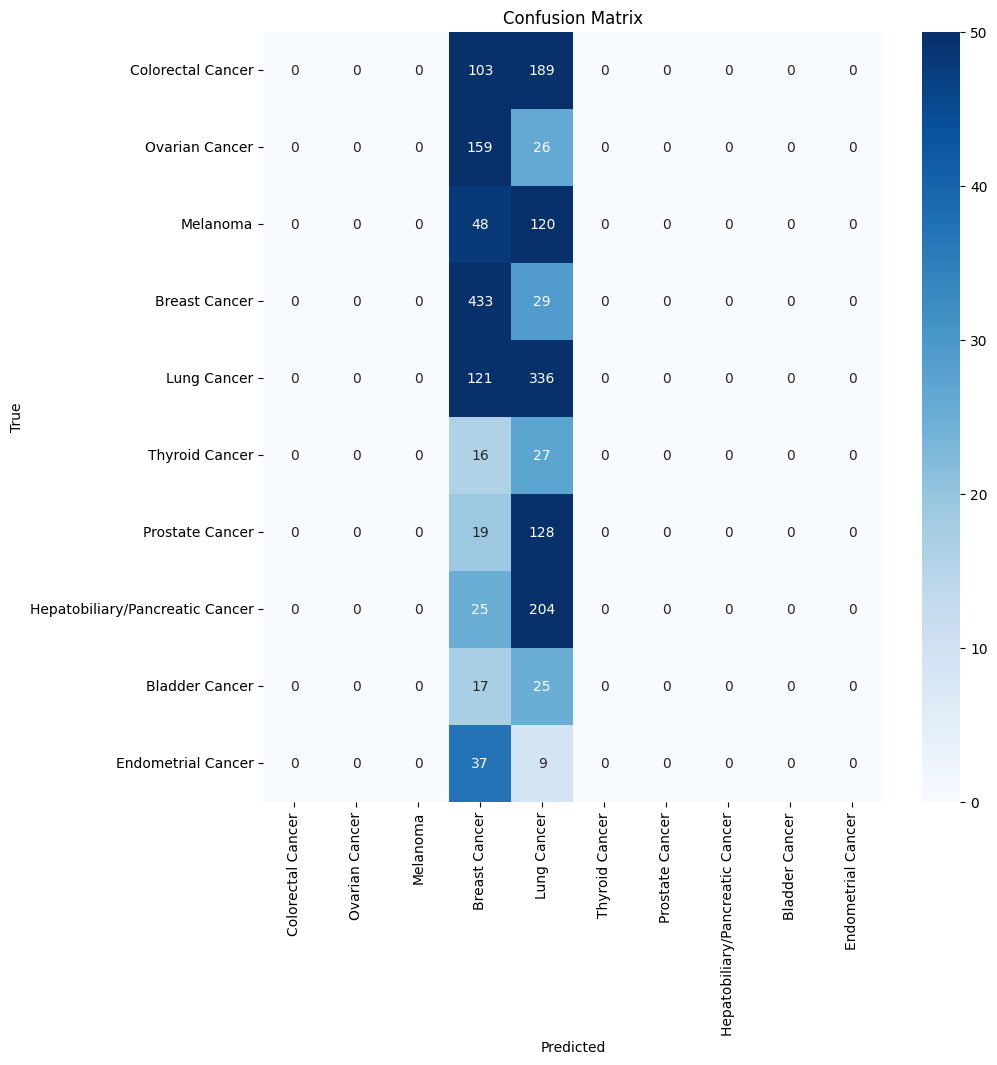

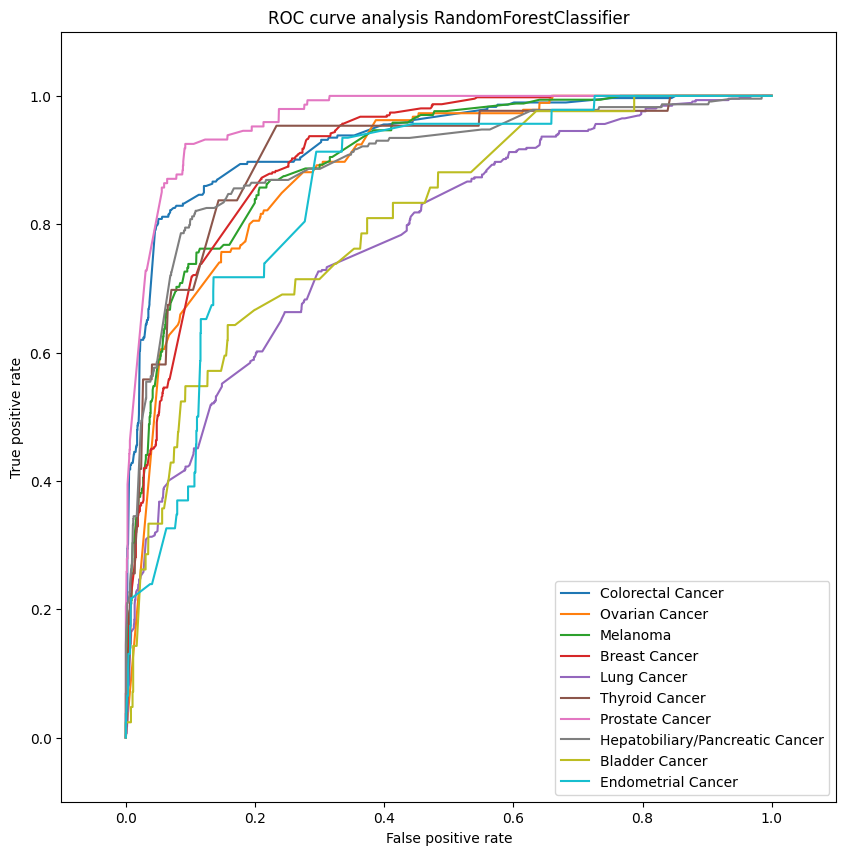

PR-AUC: 0.63


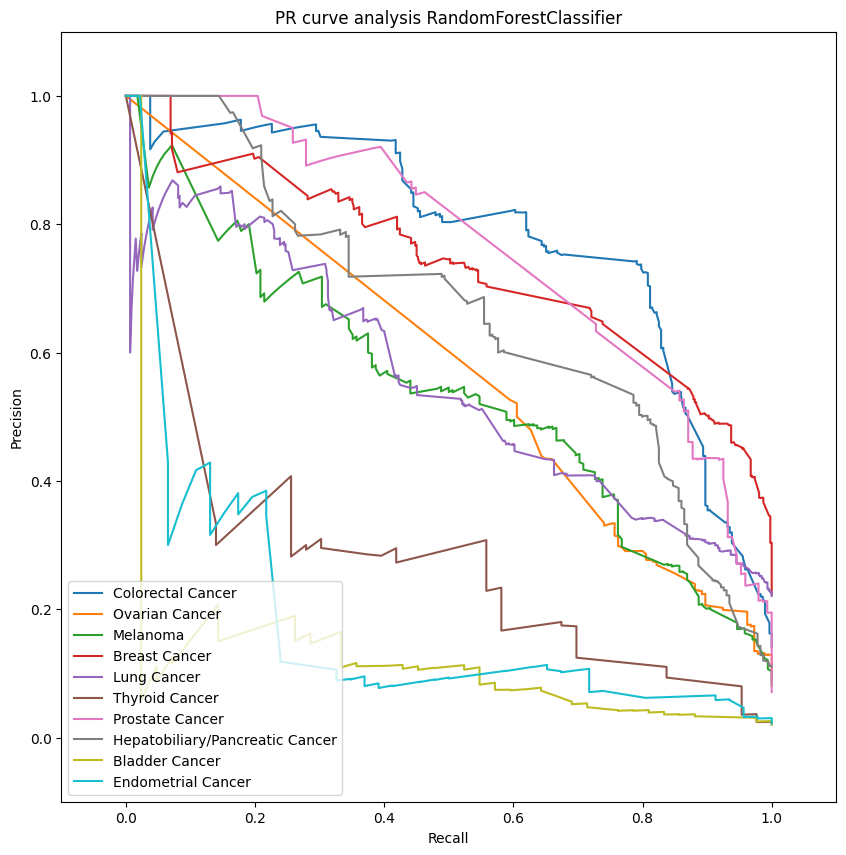

In [34]:
results.loc[0], cv_results.loc[0] = pipeline(X, y, "RandomForestClassifier")

Model: XGBoostClassifier
Accuracy: 0.81, Mean Accuracy: 0.79, Accuracy 95-CI: (0.7821277665727601, 0.7925289203436771)
Top-2 Accuracy: 0.91
F1: 0.81, Mean F1: 0.79, F1 95-CI: (0.7805391542253689, 0.790937880388933)
ROC-AUC: 0.97, Mean ROC-AUC: 0.97, ROC-AUC 95-CI: (0.9651039470969369, 0.9680305366865067)
Sensitivity per class: {'Colorectal Cancer': 0.86, 'Ovarian Cancer': 0.64, 'Melanoma': 0.86, 'Breast Cancer': 0.88, 'Lung Cancer': 0.79, 'Thyroid Cancer': 0.7, 'Prostate Cancer': 0.92, 'Hepatobiliary/Pancreatic Cancer': 0.81, 'Bladder Cancer': 0.38, 'Endometrial Cancer': 0.61}
Specificity per class: {'Colorectal Cancer': 0.98, 'Ovarian Cancer': 0.97, 'Melanoma': 0.99, 'Breast Cancer': 0.95, 'Lung Cancer': 0.95, 'Thyroid Cancer': 0.99, 'Prostate Cancer': 0.99, 'Hepatobiliary/Pancreatic Cancer': 0.97, 'Bladder Cancer': 1.0, 'Endometrial Cancer': 1.0}


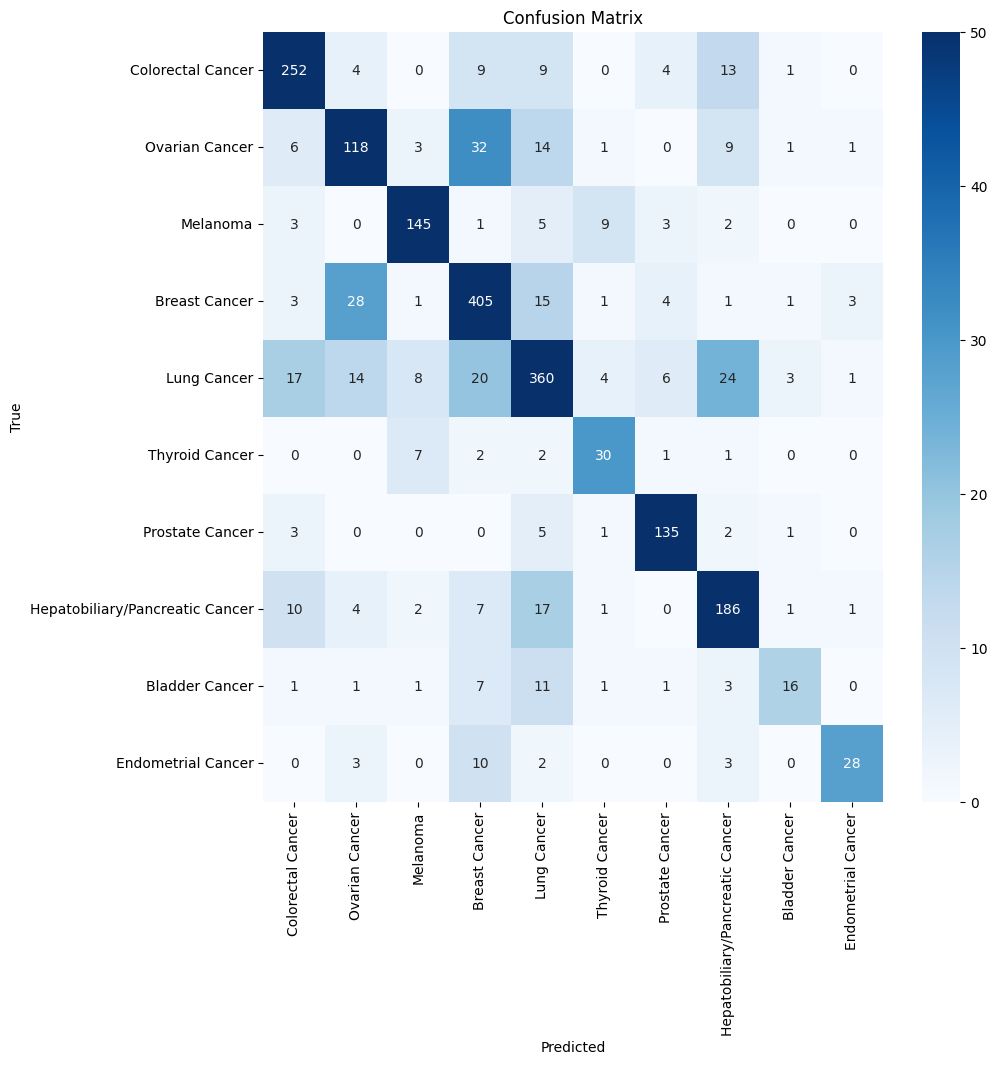

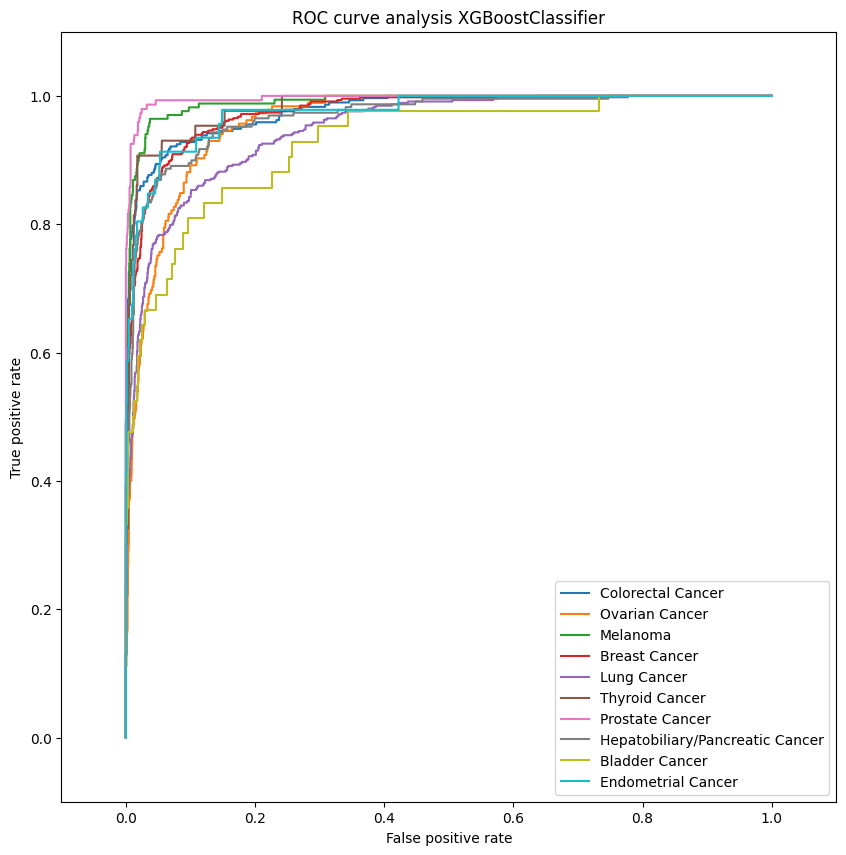

PR-AUC: 0.88


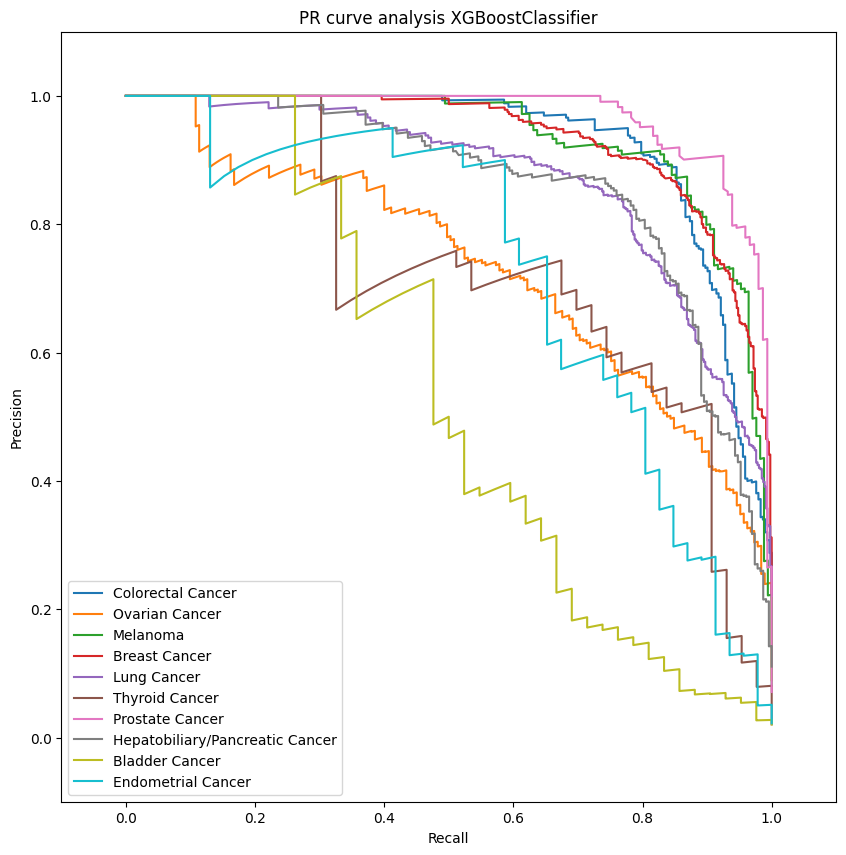

In [35]:
results.loc[1], cv_results.loc[1] = pipeline(X, y, "XGBoostClassifier")

Model: CatBoostClassifier
Accuracy: 0.8, Mean Accuracy: 0.78, Accuracy 95-CI: (0.7708781461277706, 0.7841428869099943)
Top-2 Accuracy: 0.9
F1: 0.8, Mean F1: 0.78, F1 95-CI: (0.7692357823011192, 0.7823358964273804)
ROC-AUC: 0.97, Mean ROC-AUC: 0.96, ROC-AUC 95-CI: (0.9621669615650612, 0.9656240484451195)
Sensitivity per class: {'Colorectal Cancer': 0.86, 'Ovarian Cancer': 0.64, 'Melanoma': 0.85, 'Breast Cancer': 0.88, 'Lung Cancer': 0.77, 'Thyroid Cancer': 0.67, 'Prostate Cancer': 0.93, 'Hepatobiliary/Pancreatic Cancer': 0.79, 'Bladder Cancer': 0.33, 'Endometrial Cancer': 0.54}
Specificity per class: {'Colorectal Cancer': 0.98, 'Ovarian Cancer': 0.97, 'Melanoma': 0.98, 'Breast Cancer': 0.94, 'Lung Cancer': 0.94, 'Thyroid Cancer': 0.99, 'Prostate Cancer': 0.99, 'Hepatobiliary/Pancreatic Cancer': 0.97, 'Bladder Cancer': 1.0, 'Endometrial Cancer': 1.0}


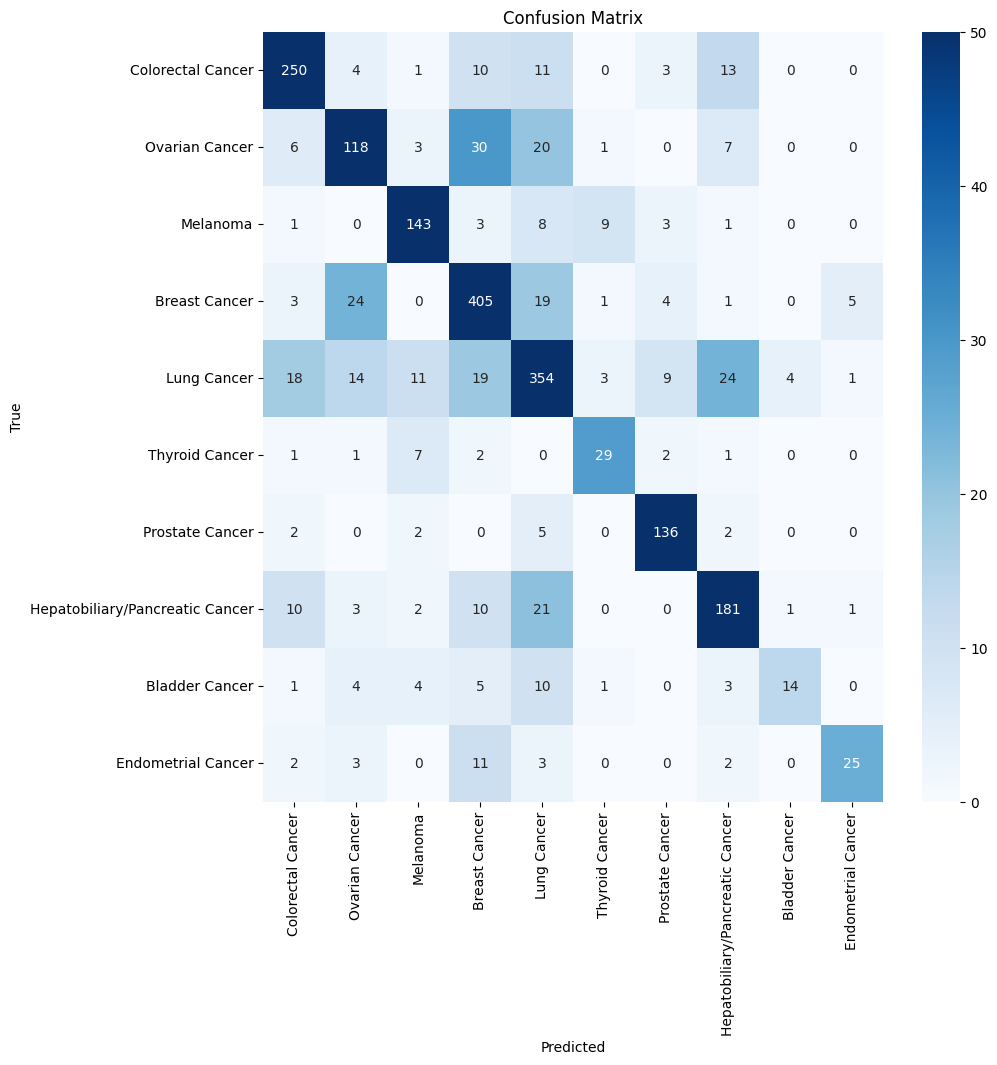

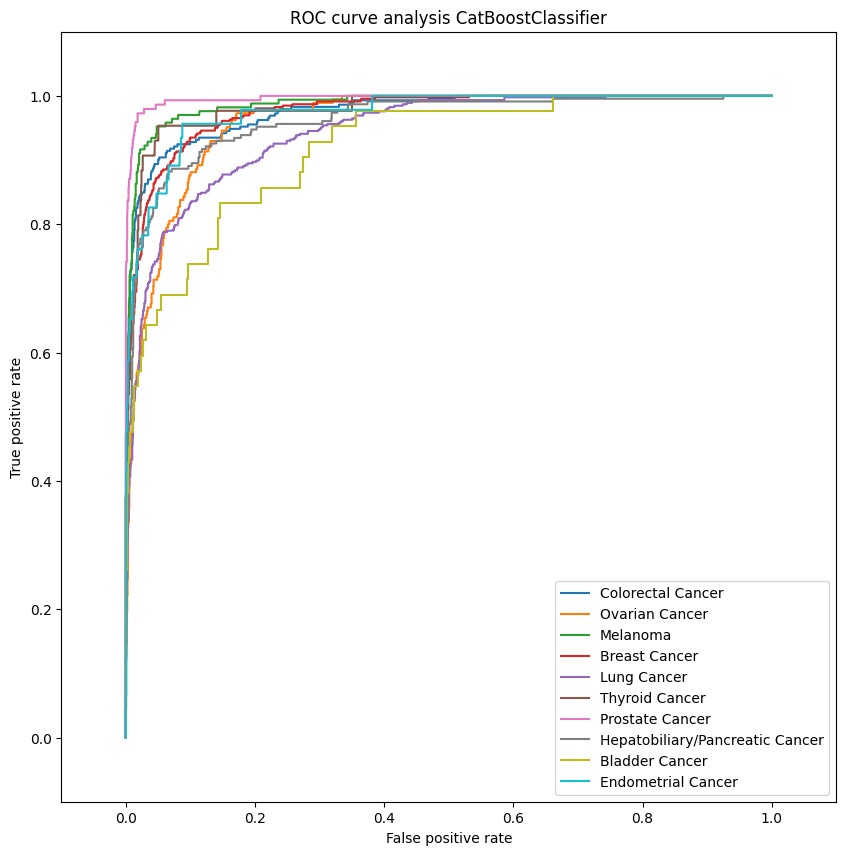

PR-AUC: 0.87


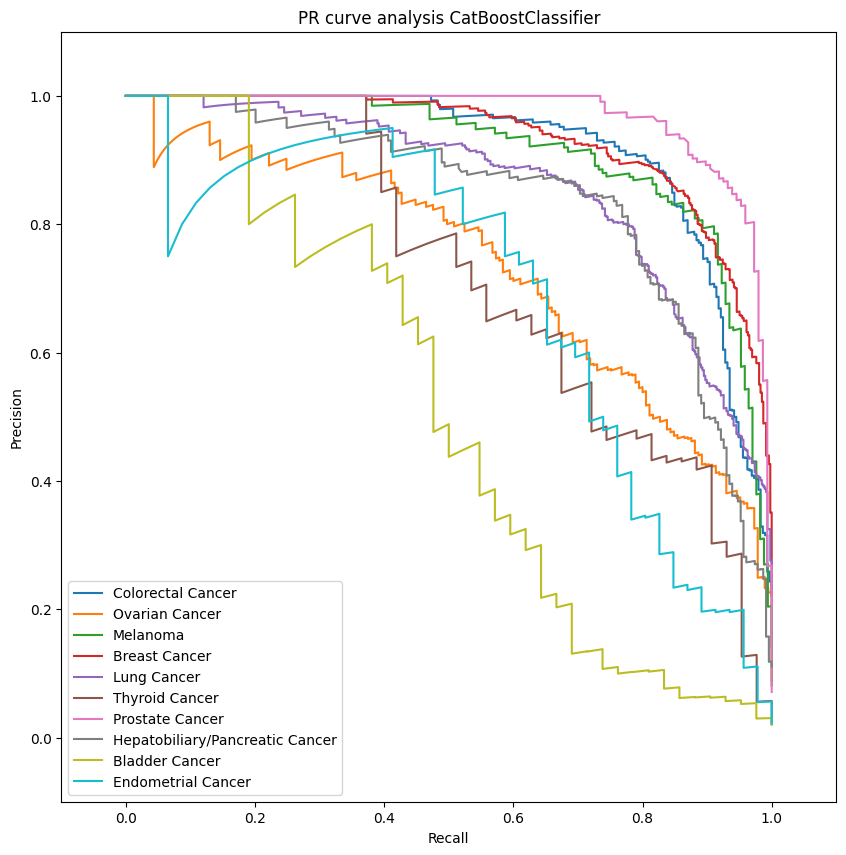

In [36]:
results.loc[2], cv_results.loc[2] = pipeline(X, y, "CatBoostClassifier")

Model: ExtraTreesClassifier
Accuracy: 0.57, Mean Accuracy: 0.55, Accuracy 95-CI: (0.5429860249898201, 0.5609386638341037)
Top-2 Accuracy: 0.74
F1: 0.56, Mean F1: 0.54, F1 95-CI: (0.532858672517642, 0.5522982946320122)
ROC-AUC: 0.91, Mean ROC-AUC: 0.9, ROC-AUC 95-CI: (0.8947312564103304, 0.9022763059800468)
Sensitivity per class: {'Colorectal Cancer': 0.79, 'Ovarian Cancer': 0.68, 'Melanoma': 0.66, 'Breast Cancer': 0.53, 'Lung Cancer': 0.15, 'Thyroid Cancer': 0.77, 'Prostate Cancer': 0.9, 'Hepatobiliary/Pancreatic Cancer': 0.82, 'Bladder Cancer': 0.5, 'Endometrial Cancer': 0.76}
Specificity per class: {'Colorectal Cancer': 0.97, 'Ovarian Cancer': 0.93, 'Melanoma': 0.97, 'Breast Cancer': 0.98, 'Lung Cancer': 1.0, 'Thyroid Cancer': 0.94, 'Prostate Cancer': 0.95, 'Hepatobiliary/Pancreatic Cancer': 0.91, 'Bladder Cancer': 0.96, 'Endometrial Cancer': 0.94}


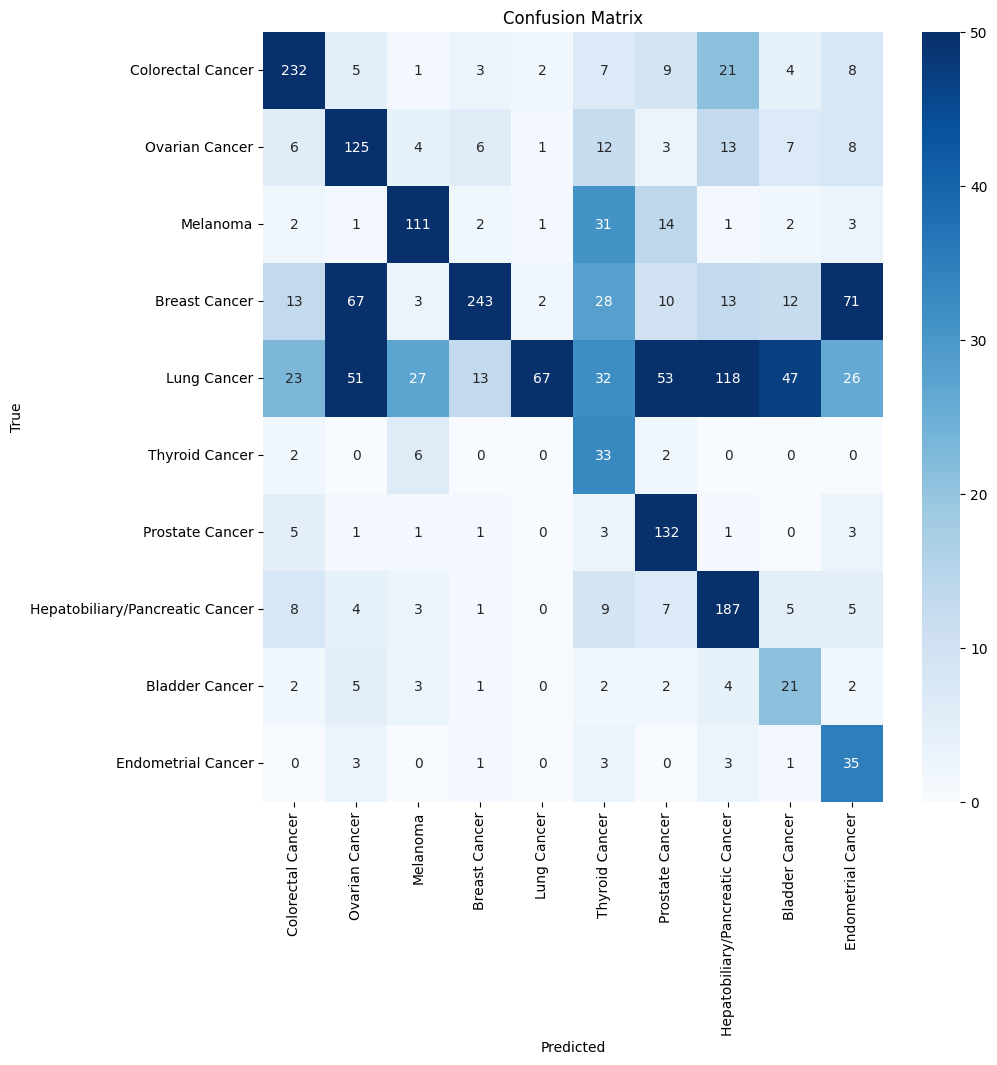

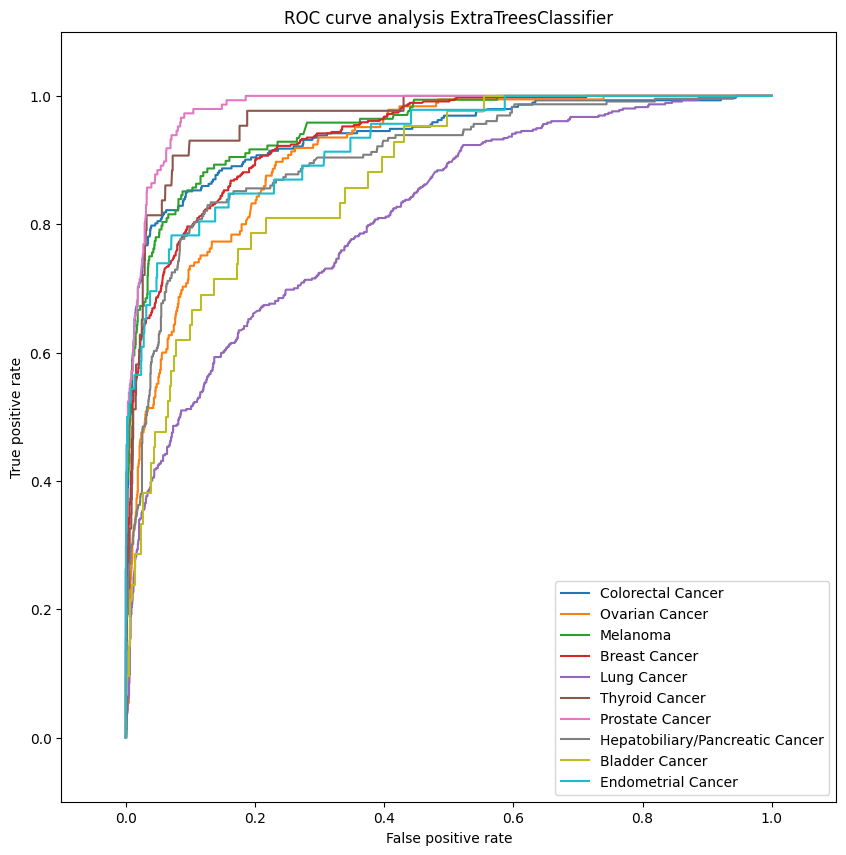

PR-AUC: 0.71


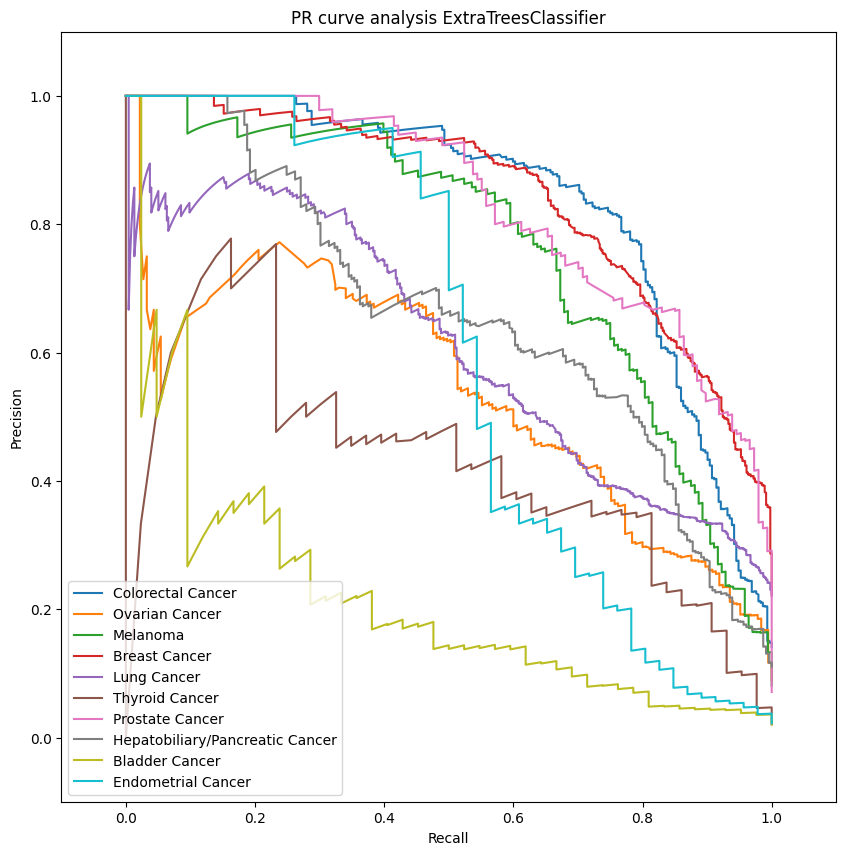

In [37]:
results.loc[3], cv_results.loc[3] = pipeline(X, y, "ExtraTreesClassifier")

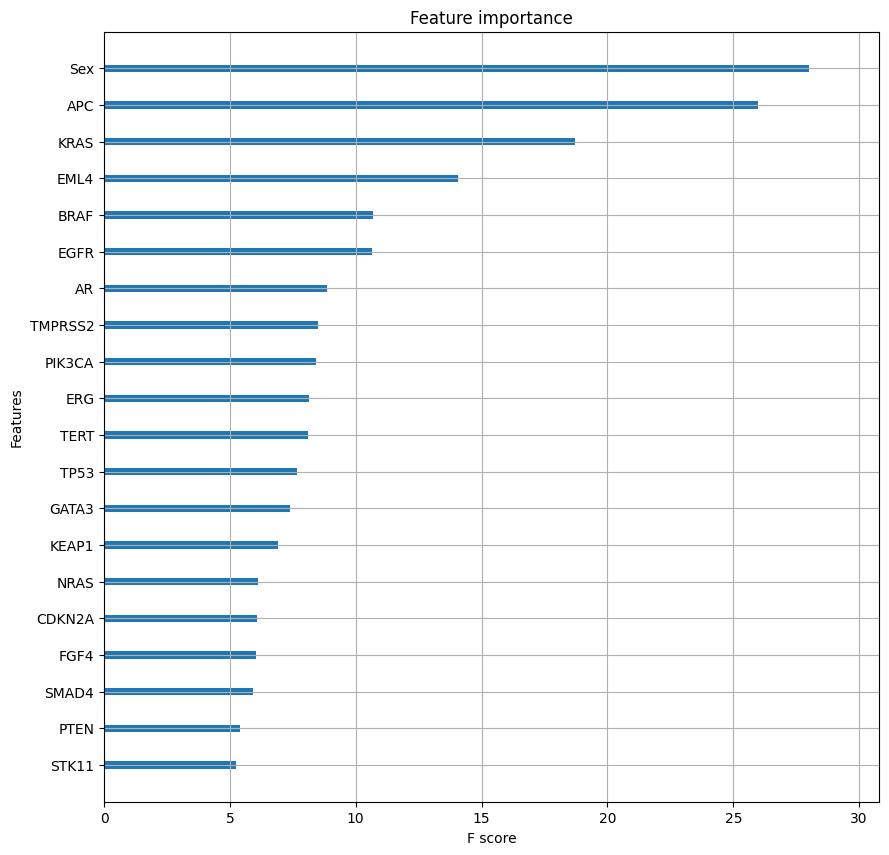

In [38]:
# Result export

cv_results.to_csv("results/cv_results.csv")
results.to_csv("results/results.csv")

# OncoOrigin model training

features = pd.read_pickle("features/selected_features.pkl")
hyperparameters = pd.read_pickle("hyperparameters/XGBoostClassifier_hyperparams.pkl")
X_fit = X[features]

model = xgb.XGBClassifier(**hyperparameters)
model.fit(X_fit, y)

# Export for OncoOrigin software

output = open("app/kernel.pkl", "wb")
pickle.dump(model, output)
output.close()

output = open("app/dictionary.pkl", "wb")
pickle.dump(num_to_cat, output)
output.close()

output = open("app/gene_list.pkl", "wb")
pickle.dump(features[2:], output)
output.close()

# Feature importance calculation based on OncoOrigin model

fig, ax = pyplt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax, importance_type='gain', max_num_features=20, show_values=False)
pyplt.show()